# Compare voxelization error metrics

We have two ways of measuring voxelization error:

- _smtherr_: average difference of mean curvature between neighbors
- _nverr_: comparison of normal vectors, normalized between \[0, 1)

Here we have an experiment to compare these two metrics.

```
/neuro/labs/grantlab/research/Jennings/for/hyukjin/smoothing
```

First, we used marching-cubes on an artificial shape to obtain a surface with large voxelization error. Then we ran `adapt_object_mesh` for a varying number of iterations (i.e. `taubin`, independent variable) to gradually decrease voxelization error.

Note: the ultimate challenge is that there is no mathematical difference between "not being smooth" and "voxelated", so the choice between _smtherr_ and _nverr_ is ultimately subjective.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from pathlib import Path

from tqdm.notebook import tqdm
import os

## Load Data

In [2]:
data_dir = Path(os.getcwd()).parent

data_files = [
    *(data_dir / '3_smtherr').glob('*.smtherr.txt'),
    *(data_dir / '4_nverr').glob('*.nverr.txt')
]

assert len(data_files) > 0

In [3]:
def load_file(p: Path) -> pd.DataFrame:
    method = p.name.split('.')[-2]
    taubin = int(p.name.split('_')[2])
    values = np.loadtxt(p, dtype=np.float32)
    if len(values) != 40962:
        raise ValueError(f'{p} contains wrong amount of data, {len(values)} != 40962')
    return pd.DataFrame({
        'method': [method] * len(values),
        'taubin': [taubin] * len(values),
        'values': values
    })


In [4]:
with tqdm(data_files) as pbar:
    df = pd.concat(load_file(data_file) for data_file in pbar)

  0%|          | 0/102 [00:00<?, ?it/s]

## Value Distribution

Look at a histogram of the values for most voxelated v.s. most smoothed surfaces.

In [5]:
df2 = df[(df.taubin == 0) | (df.taubin == 1000)]

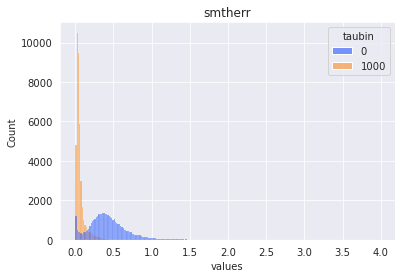

In [6]:
ax = sns.histplot(df2[df2.method == 'smtherr'], x='values', hue='taubin', palette='bright').set_title('smtherr')

Text(0.5, 1.0, 'nverr')

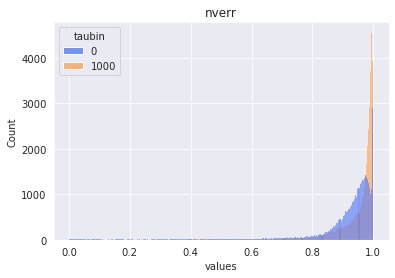

In [7]:
sns.histplot(df2[df2.method == 'nverr'], x='values', hue='taubin', palette='bright').set_title('nverr')

### Observations on distributions

- _smtherr_ distributions tend to be low and have no maximum value.
- _nverr_ distributions tend to be near 1, and 1 is the max value.
- _smtherr_ distributions are **more different** i.e. futher apart than _nverr_ between voxellated and smooth.

## Plot regression curves: smoothness v.s. error

(these will take a long time!)

In [8]:
def linear_regression(df):
    x = np.array(df['taubin'], dtype=np.float32)
    y = np.array(df['values'], dtype=np.float32)
    A = np.vstack([x, np.ones(len(x))]).T
    
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    pred = x * m + c
    r2 = r2_score(y, pred)
    print(f'y = {m:.4E}*x + {c:.4f}, r^2={r2:.4f}')

KeyboardInterrupt: 

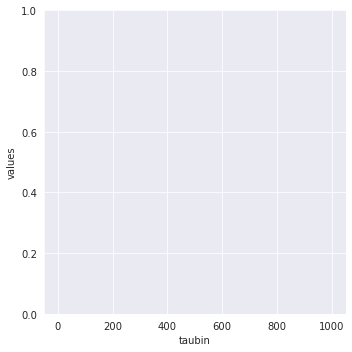

In [9]:
s = df[df.method == 'smtherr']
sns.lmplot(s, x='taubin', y='values', scatter=False).fig.suptitle('smtherr')
linear_regression(s)

In [ ]:
n = df[df.method == 'nverr']
sns.lmplot(n, x='taubin', y='values', scatter=False).fig.suptitle('nverr')
linear_regression(n)

### Observations about curves

_smtherr_ has a much stronger correlation with number of `adapt_object_mesh` iterations: comparing _r²_ values, 0.0772 \> 0.0003

Linear regression seems appropriate (up to a point, since there is an upper limit to smoothness called being flat). 
_r²_ are apparently low because of noise.

TODO: to improve correlations, we can try masking the data to include only where voxelization error exists, and disregard values where the surface is known to be OK.

### The Effect of `adapt_object_mesh` iterations on Smoothness Error

In [35]:
averaged = df[df.method == 'smtherr'].groupby(by='taubin').mean()
averaged.rename(columns={'values': 'smtherr'}, inplace=True)
averaged.to_csv('taubin_vs_smtherr.csv')